# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
from functools import reduce
import glob
import seaborn as sns

import tqdm as tqdm
from tqdm.autonotebook import tqdm
tqdm.pandas()

import sys
sys.path.append('iads/')

from utils import *

# Importation de la librairie iads
import iads as iads
# importation de LabeledSet
from iads import LabeledSet as ls
# importation de Classifiers
from iads import Classifiers as cl
# importation de utils
from iads import utils as ut

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Chargement des données (base MovieLens + enrichissements)

In [2]:
# Chargement des données MovieLens

print("Chargement des données MoviesLens")
for fname in glob.glob("ml-20m/*.csv"):
    print("\t {}...".format(fname))
    name = fname.split('/')[1].split('.')[0].replace('-', '_')
    vars()[name] = pd.read_csv(fname, encoding='utf8')
print("Done")

movies.head()
genome_scores.head()
genome_tags.head()
links.head()
ratings.head()
tags.head()

Chargement des données MoviesLens
	 ml-20m/links.csv...
	 ml-20m/tags.csv...
	 ml-20m/genome-tags.csv...
	 ml-20m/ratings.csv...
	 ml-20m/genome-scores.csv...
	 ml-20m/movies.csv...
Done


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [3]:
# Chargement des données complémentaires

print("Chargement des données complémentaires")
for fname in glob.glob("ml-20m/*.pkl"):
    print("\t {}".format(fname))
    name = fname.split('/')[1].split('_')[0]
    vars()[name] = pkl.load(open(fname, "rb"))
print("Done")



Chargement des données complémentaires
	 ml-20m/film_v2.pkl
	 ml-20m/act_v2.pkl
	 ml-20m/crew_v2.pkl
Done


In [4]:
len(tags.tag.unique())
genome_tags.shape

38644

(1128, 2)

In [5]:
act[0][0]

{'cast_id': 14,
 'character': 'Woody (voice)',
 'credit_id': '52fe4284c3a36847f8024f95',
 'gender': 2,
 'id': 31,
 'name': 'Tom Hanks',
 'order': 0,
 'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'}

In [6]:
crew[0][0]

{'credit_id': '52fe4284c3a36847f8024f49',
 'department': 'Directing',
 'gender': 2,
 'id': 7879,
 'job': 'Director',
 'name': 'John Lasseter',
 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}

In [7]:
film[:1]

[{'adult': False,
  'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
  'genre_ids': [16, 35, 10751],
  'id': 862,
  'original_language': 'en',
  'original_title': 'Toy Story',
  'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
  'popularity': 22.773,
  'poster_path': '/rhIRbceoE9lR4veEXuwCC2wARtG.jpg',
  'release_date': '1995-10-30',
  'title': 'Toy Story',
  'video': False,
  'vote_average': 7.9,
  'vote_count': 9550}]

## Mise en forme des données

In [8]:
unique_cat = set(reduce(lambda a, b: a + b, movies.apply(
    lambda x: x.genres.split('|'), axis=1)))

In [9]:
movies[list(unique_cat)] = pd.DataFrame(np.zeros((movies.shape[0], 
                                                  len(unique_cat))))
for i, row in movies.iterrows():
    movies.loc[i, row['genres'].split('|')] = 1

In [10]:
# %load preprocessing.py
#!/usr/bin/env python3

"""

"""

def process_ratings(ratings, fname_to_create):
    """FIXME! briefly describe function

    :param ratings:
    :param fname_to_create:
    :returns:
    :rtype:

    """

    # Calculate ratings mean of users
    df_ratings = ratings[['movieId', 'rating']].groupby(
        ['movieId'], as_index=False).mean()

    # Count number of ratings by movie
    df_ratings['nb_ratings'] = ratings.groupby(
        ['movieId'], as_index=False).count().loc[:, 'rating']

    df_ratings.to_csv(fname_to_create, index=False)


def process_tags(tags, fname_to_create):
    """FIXME! briefly describe function

    :param tags:
    :param fname_to_create:
    :returns:
    :rtype:

    """

    df_tags = tags[['movieId', 'userId']].groupby(
        ['movieId'], as_index=False).count().rename(
        columns={'userId': 'nb_tags'})

    df_tags['all_tags'] = tags.groupby(['movieId'], as_index=False)[
        'tag'].progress_apply(list)

    df_tags['existing_tags'] = df_tags[['all_tags']].progress_apply(
        lambda line: list(filter(
            lambda tag: not genome_tags[genome_tags['tag'] == tag].empty,
            line['all_tags'])), axis=1)

    df_tags['existing_tagsId'] = df_tags[['existing_tags']].progress_apply(
        lambda line: list(map(
            lambda tag: genome_tags[genome_tags['tag']
                                    == tag]['tagId'].iloc[0],
            line['existing_tags'])), axis=1)

    df_tags['existing_tagsRelevance'] = df_tags[['movieId', 'existing_tagsId']].progress_apply(
        lambda line: np.array(
            [*map(lambda tagId:
                  genome_scores[(genome_scores['movieId'] == line.movieId) &
                                (genome_scores['tagId'] == tagId)]['relevance'].values,
                  line['existing_tagsId'])]).ravel(), axis=1)

    df_tags['mean_relevance'] = df_tags[['existing_tagsRelevance']].progress_apply(
        lambda line: line['existing_tagsRelevance'].mean(), axis=1).fillna(0)

    df_tags.to_csv(fname_to_create, index=False)


def main():

    process_ratings(ratings, "datasets/ratings.csv")
    process_tags(tags, "datasets/tags.csv")


if __name__ == "__main__":
    process_ratings(ratings, "datasets/ratings.csv")


'\n\n'

In [11]:
df_ratings = pd.read_csv("datasets/ratings.csv")
df_tags = pd.read_csv('datasets/tags.csv')

In [12]:
try:
    df_movies = reduce(lambda df1, df2: pd.merge(df1, df2), 
                       [movies.drop(columns='title', inplace=True), 
                        links,
                        pd.DataFrame(film).rename(columns={'id':'tmdbId'})])
except:
    df_movies = reduce(lambda df1, df2: pd.merge(df1, df2), 
                       [movies, 
                        links,
                        pd.DataFrame(film).rename(columns={'id':'tmdbId'})])


In [13]:
# %load utils.py
#!/usr/bin/env python3

from datetime import datetime

import iads as iads
from iads import LabeledSet as ls


def delete_columns(data, columns_to_drop):
    """ Delete specified columns in columns_to_drop from the dataframe
    :param data: dataframe from which to delete columns
    :param columns_to_drop: list of columns to delete
    :returns: a dataframe
    :rtype: pandas.DataFrame
    """

    for column in columns_to_drop:
        if column in data.columns:
            data.drop(column, axis=1, inplace=True)

    return data


def transform_date(x, by='year'):
    """FIXME! briefly describe function

    :param x:
    :returns:
    :rtype:

    """

    try:
        if by == 'month':
            return datetime.strptime(x, '%Y-%m-%d').month
        elif by == 'day':
            return datetime.strptime(x, '%Y-%m-%d').day
        return datetime.strptime(x, '%Y-%m-%d').year
    except BaseException:
        try:
            return int(x)
        except BaseException:
            return 0


def createLabeledSet(X, y):
    """FIXME! briefly describe function

    :param X:
    :param y:
    :returns:
    :rtype:

    """

    l = ls.LabeledSet(X.shape[0])
    for i, j in zip(X, y):
        l.addExample(i, j)

    return l

def normalize(X):
    """ Returns a normalized (between 0 and 1) array of X. Normalizes each
    column separatly.
    :param X: independent variables, features.
    :returns: a normalized X
    :rtype: np.array
    """

    norm_X = np.zeros_like(X)
    for i in range(X.shape[1]):
        tmp = X[:, i].copy()
        maxi, mini = np.nanmax(tmp), np.nanmin(tmp)
        norm_X[:, i] = (tmp - mini) / (maxi - mini)

    return norm_X

def split(labeledSet, test_size):
    """
    """
    
    indexes = np.arange(labeledSet.size())
    np.random.shuffle(indexes)
    
    shuffeledSet = ls.LabeledSet(2)
    for i in indexes:
        shuffeledSet.addExample(labeledSet.getX(i), labeledSet.getY(i))
    
    trainSet, testSet = ls.LabeledSet(2), ls.LabeledSet(2)
    test_range = int(labeledSet.size() * test_size)
    
    for i in range(labeledSet.size() - test_range):
        trainSet.addExample(shuffeledSet.getX(i), shuffeledSet.getY(i))
    
    for i in range(labeledSet.size() - test_range, labeledSet.size()):
        testSet.addExample(shuffeledSet.getX(i), shuffeledSet.getY(i))
    
    return trainSet, testSet

def replace(dico, key):
    try:
        return dico[key]
    except BaseException:
        return -1

In [14]:
# Drop NaN values
df_movies = df_movies.dropna()
df_y = df_movies['vote_average'].copy()

## Regression Model : Sans Kernel, Kernel Bias et Kernel Poly

__Problème traité__ : *Prédire la note moyenne des films*

-----------------
Nous envisageons de tester la régréssion avec différents paramètres, particulièrement en variant les variables de $X$, en y ajoutant ou en y retirant quelques unes à chaque fois, tout en espérant que nos différentes idées de **feature engeneering** apportent leur fruit au score final. Pour chaque $X$ que nous définirons, nous testerons cependant le modèle de régréssion, premièrement **sans Kernel**, avec le **kernel Bias**, et avec le **kernel poly**, mais aussi en variant le **taux d'apprentissage** et le **nombre maximum d'itérations** de la descente de gradient afin de comparer les performances et trouver les paramètres **optimaux**. Quant à cette dernière nous avons choisi d'implémenter notre modèle suivant la **descente de gradient bash** car juger plus rapide et computationnellement possible en l'occurence.

In [15]:
class Regressor(cl.Classifier):
    """ Classe réprésentant une régression.
    """

    def __init__(self, dimension_kernel, learning_rate, kernel, max_iter=10):
        """
        """

        self.dimension_kernel = dimension_kernel
        self.learning_rate = learning_rate
        self.kernel = kernel
        self.max_iter = max_iter
        self.w = np.zeros(self.dimension_kernel)
 
    def predict(self, x):
        """ 
        """
        
        return self.kernel.transform(x).dot(self.w.T)

    def train(self, labeledSet):
        """ 
        """
        for _ in range(self.max_iter):
            f = self.kernel.transform(labeledSet.x).dot(self.w.T).reshape(-1, 1)
            mse_g = -2 * (self.kernel.transform(labeledSet.x) * 
                          (labeledSet.y - f)).mean(axis=0)
            self.w -= self.learning_rate * mse_g
            
    def accuracy(self, labeledSet):
        """
        """
        mse = np.mean((self.predict(labeledSet.x)[:, np.newaxis] - labeledSet.y)**2)
        return mse
        
    def plot_results(self, y, y_pred, title, ax=None, cmap='viridis'):
        """
        """
        
        if ax is None:
            fig, ax = plt.subplots(1, figsize=(16, 6))
        
        results = pd.DataFrame(np.hstack((y, y_pred[:, np.newaxis])), 
                               columns=['y', 'y_pred'], 
                               index=range(len(y_pred)))
        results.plot(ax=ax, cmap=cmap)
        ax.set_title(title)

In [16]:
def plot_regression_experiences(regressor_set, train_set, test_set, cmaps = ['viridis', 'plasma', 'summer']
):
    """
    """
    
    kernels = [cl.NoKernel(), cl.KernelBias(), cl.KernelPolytwo()]
    dimensions = [regressor_set.x.shape[1], 
                  regressor_set.x.shape[1]+1, 
                  1+regressor_set.x.shape[1]*2]
    titles = ['Valeurs Prédites vs Réelles sans kernel',
              'Valeurs Prédites vs Réelles avec Kernel Bias',
              'Valeurs Prédites vs Réelles avec Kernel Poly']
    epsilons = [0.5, 0.1, 0.01]
    max_iters = [3, 50, 300]

    fig, ax = plt.subplots(len(epsilons), len(kernels), figsize=(16, 5*len(epsilons)))
    for i, (eps, max_iter) in enumerate(zip(epsilons, max_iters)):
        for k, kernel in enumerate(kernels):
            regressor = Regressor(dimensions[k], eps, kernel, max_iter)
            regressor.train(train_set)
            y_pred = regressor.predict(test_set.x)
            score = regressor.accuracy(test_set)
            title = titles[k] + "\n avec eps: {} et max_iter: {} \n MSE: {} \n RMSE: {}".format(
                eps, max_iter, score, np.sqrt(score))
            regressor.plot_results(test_set.y, y_pred, title, ax=ax[i, k], cmap=cmaps[k])

    plt.tight_layout()
    
    
def plot_erreur_curve(regressor_set, train_set, test_set, eps, max_iters, kernel, dim_kernel):
    
    scores = []
    for max_iter in max_iters:
        regressor = Regressor(dim_kernel, eps, kernel, max_iter)
        regressor.train(train_set)
        y_pred = regressor.predict(test_set.x)
        scores.append(regressor.accuracy(test_set))
             
    plt.figure(figsize=(16, 6))
    plt.grid()
    plt.plot(max_iters, np.sqrt(scores), label='RMSE')
    title = "Courbes d\'erreurs RMSE selon le nombre max d\'iterations " \
            "\n avec eps: {} et kernel: {}".format(eps, kernel)
    plt.title(title)
    plt.xlabel("Number of iterations")
    plt.ylabel("Root Mean Square Error \(RMSE\)")
    plt.legend()
    
def correlation_matrix(df_X, df_y, annot=False, cmap='cubehelix', size=(16, 12)):
    """
    """
    
    corr = pd.concat([df_X, df_y], axis=1).corr()
    plt.figure(figsize=size)
    plt.title('Matrice de corrélation', fontsize=18)
    sns.heatmap(corr, annot=annot, cmap=cmap, linewidths=0.2, annot_kws={'size': 10})
    plt.show()

### First Set (catégorie des films)

Dans ce qui suit, nous allons commencé par tester nos modèles de régréssion en utilisant tout simplement les catégories des films que nous avons transformé par **dummy encoding**.

In [17]:
basic_X = df_movies.iloc[:, 2:22]
basic_X.head()
basic_X.describe()

,Horror,Fantasy,Children,Adventure,Sci-Fi,Western,Romance,Crime,Film-Noir,War,Musical,Drama,Animation,Thriller,Mystery,IMAX,Documentary,(no genres listed),Action,Comedy
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,Horror,Fantasy,Children,Adventure,Sci-Fi,Western,Romance,Crime,Film-Noir,War,Musical,Drama,Animation,Thriller,Mystery,IMAX,Documentary,(no genres listed),Action,Comedy
count,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000,24218.000000
mean,0.101412,0.054298,0.044554,0.090305,0.068172,0.026468,0.157362,0.113428,0.013420,0.045421,0.039062,0.491907,0.038566,0.162730,0.058593,0.007763,0.070361,0.005203,0.137831,0.318606
std,0.301880,0.226610,0.206326,0.286624,0.252047,0.160525,0.364150,0.317122,0.115066,0.208229,0.193746,0.499945,0.192563,0.369127,0.234866,0.087766,0.255760,0.071944,0.344730,0.465945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Voyons quelles sont les catégories de films qui sont assez récurrentes.

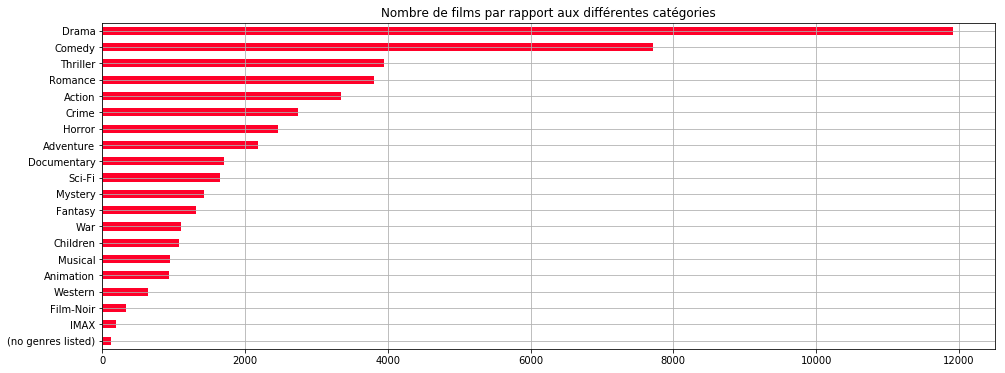

In [18]:
basic_X[basic_X == 1].count().sort_values().plot(kind='barh', grid=True, 
                                                 cmap='gist_rainbow', 
                                                 title='Nombre de films par rapport aux différentes catégories',
                                                 figsize=(16, 6));

Nous remarquons que les catégories **Drama** et **Comédie** sont relativement bien plus présentes que les autres.

Nous allons prendre toutes les colonnes pour ainsi créer notre $labeledSet$. Quant aux labels $y$, ils réprésentent la moyenne des notes des utilisateurs pour un film donné, variable déja présente dans le fichier $film.pkl$ sous le nom **vote_average**.

In [19]:
df_y.head()
df_y.describe()

0    7.9
1    7.1
2    6.5
3    6.1
4    6.1
Name: vote_average, dtype: float64

count    24218.00000
mean         6.23350
std          1.16202
min          0.00000
25%          5.70000
50%          6.40000
75%          7.00000
max         10.00000
Name: vote_average, dtype: float64

La description de la variable $y$ nous dit que la presque totalité des moyennes sont dans l'intervalle **[5,7]**. Nous allons afficher l'estimation de densité de la variable pour montrer cela visuellement.

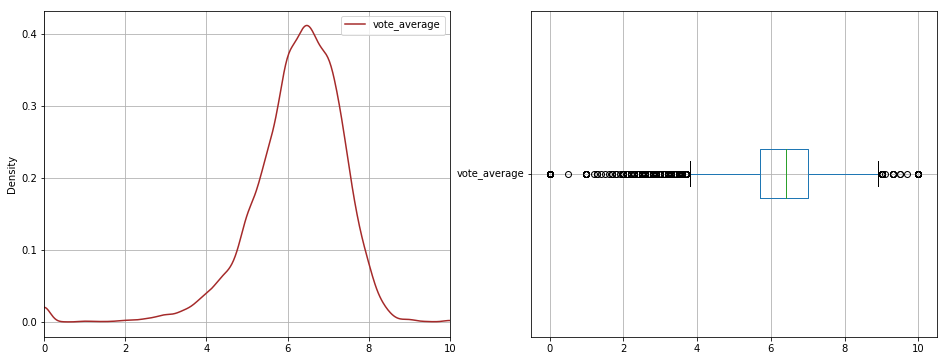

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_y.plot(kind='kde', legend=True, color='brown', grid=True, xlim=(0, 10), ax=ax1);
df_y.T.plot(kind='box', vert=False, grid=True, ax=ax2);

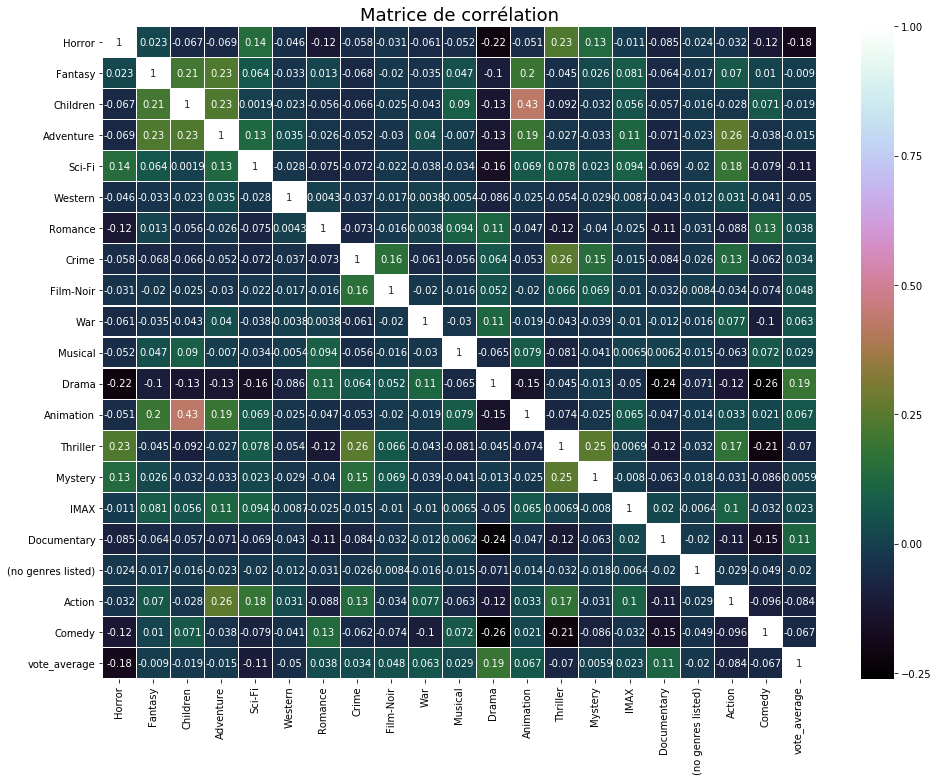

In [21]:
correlation_matrix(basic_X, df_y, annot=True)

La première chose qui nous interpelle systématiquement est la corrélation entre les catégories **Children** et **Animation**. Ce qui est plutôt cohérent sachant que la plupart des films pour enfant sont animés. Il en va de même pour les catégories, **Thriller** et **Mystery** ainsi que **Action** et **Aventure**. 

Puis par rapport à la variable **vote_average** correspondant à nos labels, nous distinguons, la catégorie **Drame** la plus populaire et la catégorie **Horror** corrélées respectivement de manière positive et négative. S'en suivent ensuite les catégories **Documentary** et **Sci-Fi**

In [22]:
note_means_cat = []
for cat in unique_cat:
    note_means_cat.append(df_movies[df_movies[cat] == 1].groupby(
        cat).mean().vote_average.values[0])

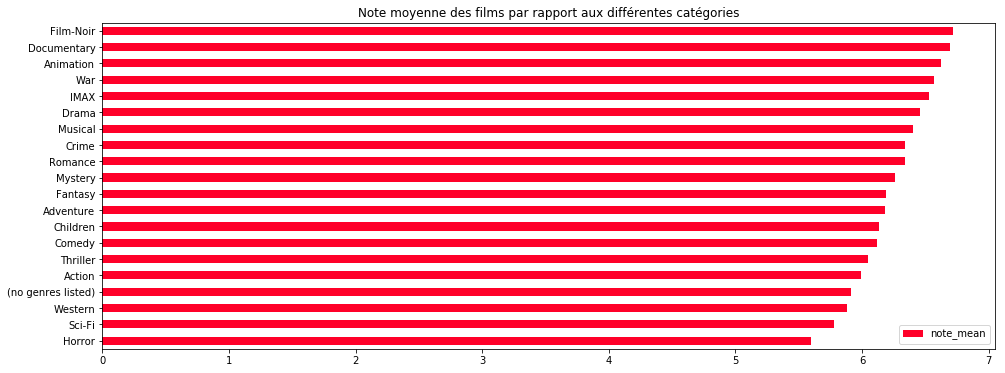

In [23]:
df_note_means_cat = pd.DataFrame(np.array(note_means_cat).reshape(1, -1),
                                 columns=unique_cat, index=['note_mean'])
df_note_means_cat.T.sort_values(by='note_mean').plot(kind='barh',
                                                     cmap='gist_rainbow', 
                                                     title='Note moyenne des films par rapport aux différentes catégories',
                                                     figsize=(16, 6));

In [24]:
X = basic_X.values
y = df_y.values
regressor_set = createLabeledSet(X, y)

In [25]:
train_set, test_set = split(regressor_set, 0.3)

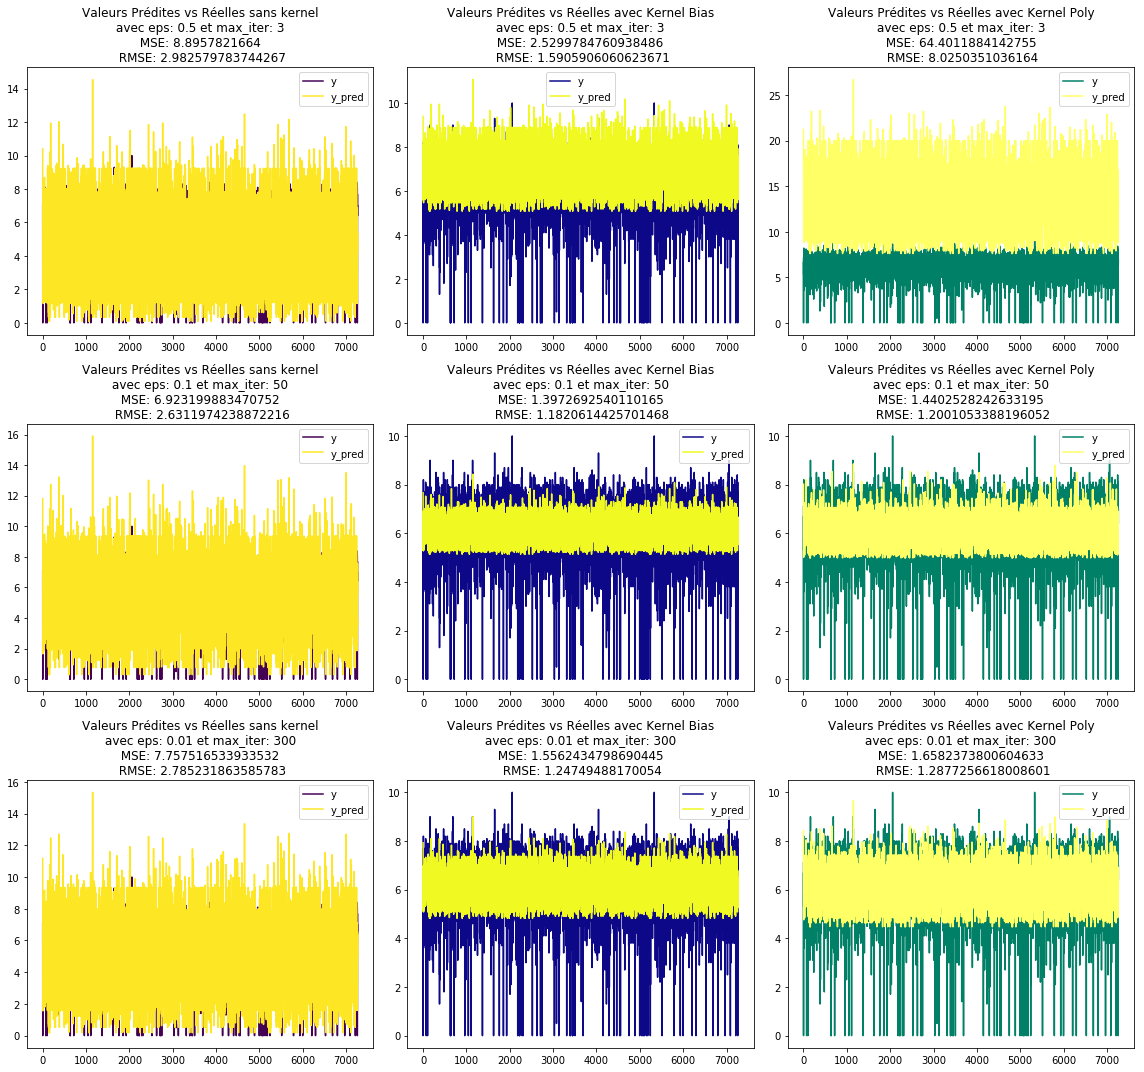

In [26]:
plot_regression_experiences(regressor_set, train_set, test_set)

Sur ces différentes expériences, nous pouvons d'office constater que quand le **taux d'apprentissage** est fixé à $0.5$ et qu'en plus le **nombre maximum d'itérations** n'est qu'à $3$, la descente de gradient ne converge pas vers le minimum global, mais vers les minimums locaux potentiellement, néanmoins avec le **Kernel Bias**, la **descente de gradient** semble converger quand même tant bien que mal.

Quant à la seconde ligne de plot, nous avons fixé le **taux d'apprentissage** à $0.1$ et le **nombre maximum d'itérations** à $50$, le **Kernel Bias** nous donne encore une fois de bons résultats. En comparant avec la dernière ligne de plot où le **taux d'apprentissage** est de $0.01$ et le **nombre maximum d'itérations** de $300$, nous concluons donc que $0.1$ est un bon compromis en **taux d'apprentissage** car avec un **taux** plus faible, il faudra donner un **nombre maximum d'itérations** plus conséquent pour espérer atteindre la convergence.

Maintenant voyons après combien d'itérations nous atteignons la convergence avec un **taux d'apprentissage** fixé à 0.1

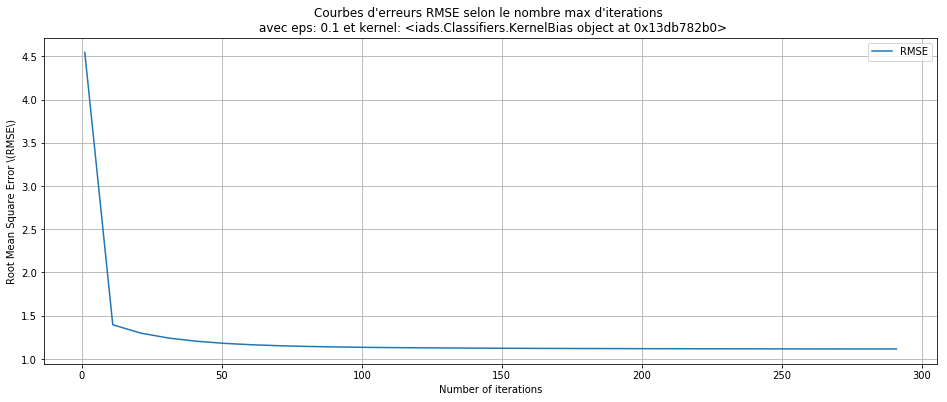

In [27]:
plot_erreur_curve(regressor_set, train_set, test_set, 0.1, range(1, 300, 10), 
                  cl.KernelBias(), regressor_set.x.shape[1]+1)

Après seulement $15$ itérations, l'algorithme semble avoir converger, en faisant de même avec un **taux d'apprentissage** de $0.01$, nous avons:

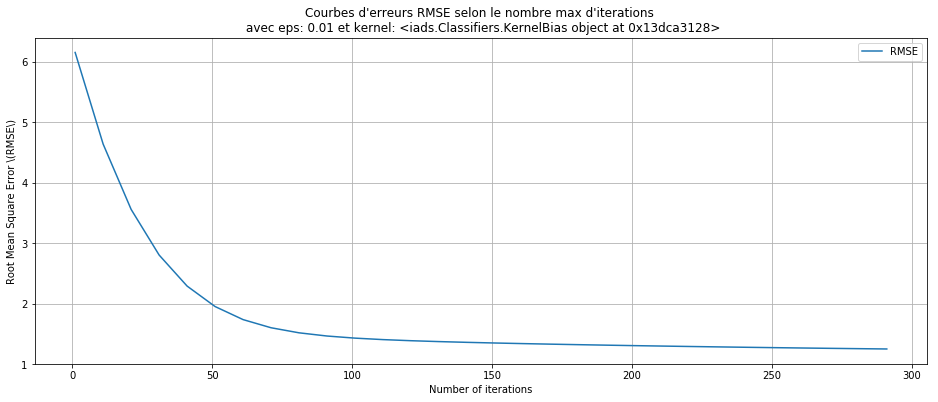

In [28]:
plot_erreur_curve(regressor_set, train_set, test_set, 0.01, range(1, 300, 10), 
                  cl.KernelBias(), regressor_set.x.shape[1]+1)

Sans surprise, il faut un nombre bien plus élevé d'itérations, plus de $250$ pour converger.

### Second Set

En gardant le même procédé d'études, nous allons maintenant appliquer notre régréssion sur un ensemble variables $X=(x1,...x23,...)$ plus riche que le premier set, en espérant améliorer le score. En plus de la base $X$ utilisée dans le **First Set**, nous avons pris en compte certaines variables qui nous paraissaient intéressantes et qui sont présentes dans le fichier $films.pkl$, telles que la **date de parution** du film que nous avons pris soin d'encoder, la **popularité**, la **langue originale** que nous avons tout aussi bien encoder.

In [29]:
# Deleting useless columns
df_X = df_movies.copy()
cols_to_drop = ['genres', 'imdbId', 'tmdbId', 'backdrop_path', 'genre_ids', 
                'original_title', 'overview', 'poster_path', 'vote_average', 
                'vote_count', 'video', 'title', 'adult']

df_X = delete_columns(df_X, cols_to_drop)

# Label encoding 
df_X['original_language'] = df_X['original_language'].astype('category').cat.codes

# Methode 1: Date Features creation
df_X['year'] = df_X['release_date'].apply(lambda x: transform_date(x, by='year'))
df_X['month'] = df_X['release_date'].apply(lambda x: transform_date(x, by='month'))
df_X['day'] = df_X['release_date'].apply(lambda x: transform_date(x, by='day'))

df_X.year[df_X.year == 0] = df_X.year.median()
df_X.month[df_X.month == 0] = df_X.month.median()
df_X.day[df_X.day == 0] = df_X.day.median()

# Methode 2: Différence en nombre de jours par rapport à maintenant
df_X['nb_days_to_now'] = df_X.release_date.apply(lambda x: (datetime.now() - 
                                                 datetime.strptime(x, '%Y-%m-%d')).days)
df_X = delete_columns(df_X, ['release_date'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


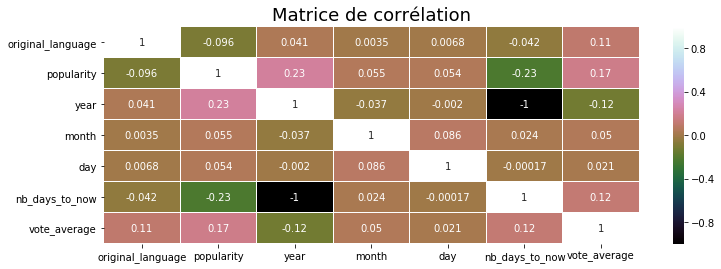

In [30]:
correlation_matrix(df_X.iloc[:, 21:], df_y, annot=True, size=(12, 4))

Après avoir transformer la variable **date de parution** en 3 différentes features qui sont : année, mois et jour. Nous avons utilisé une seconde méthode de transformation de date qui est la différence en nombre de jours des **dates de parution** jusqu'aujourd'hui. Afin d'éviter d'utiliser des variables redondantes et pour nous permettre de mieux choisir celles qui sont corrélées à notre label **vote_average**, nous avons encore affiché la matrice de corrélation. 

D'abord, il ne nous échappe pas que l'année est négativement corrélée et à $100%$ à la différence en nombre de jours. Donc, nous pouvons tout simplement choisir entre l'une ou l'autre de ces deux variables, nous avons penché pour la variable qui correspond à la différence en nombre de jours. Et tout naturellement, les autres variables comme **original_language**, **popularity** s'en suivent car corrélées, elles aussi à nos labels.

In [31]:
# Drop year, month and day
df_X = delete_columns(df_X, ['year', 'month', 'day'])
second_set = df_X.iloc[:, 1:]
# Normalize and Create LabeledSet
X = second_set.values
X = normalize(X)
reg_second_set = createLabeledSet(X, y)

In [32]:
train_set, test_set = split(reg_second_set, 0.3)

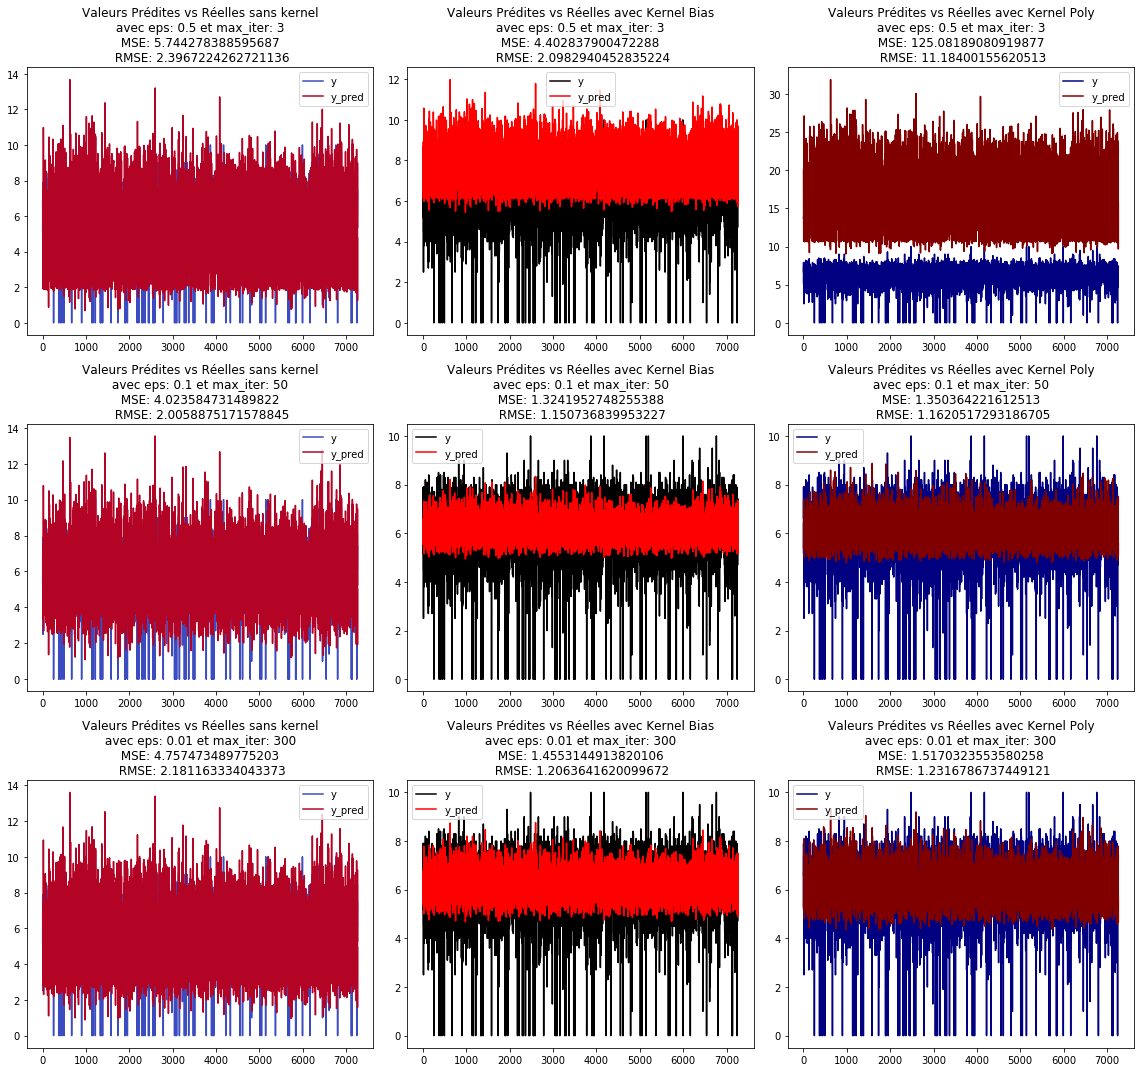

In [33]:
plot_regression_experiences(reg_second_set, train_set, test_set,
                           cmaps=['coolwarm', 'flag_r', 'jet'])

Nous constatons que nous avons de meilleurs résultats que notre dernière expérimentation avec le **First Set**. En l'occurence, notre modèle de regréssion avec le **Kernel Bias** avec comme **taux d'apprentissage** $0.1$ et comme **nombre maximum d'itérations** $50$, nous donne une sensible amélioration de la performance.

## Classification 

En ce qui concerne la classification, nous allons utiliser la base de données $kaggle-movies.csv$

In [34]:
df_kaggle_movies = pd.read_csv("datasets/kaggle-movies.csv", encoding='ISO-8859-1')
df_kaggle_movies.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


### Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [35]:
class ClassifierPerceptronKernel(cl.Classifier):
    def __init__(self,dimension_kernel,learning_rate,kernel):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        ##TODO
        self.dimension_kernel = dimension_kernel
        self.learning_rate = learning_rate
        self.kernel = kernel
        self.w = np.random.rand(self.dimension_kernel)
        
    def predict(self,x):
        """ rend la prediction sur x (-1 ou +1)
        """
        return np.sign(np.dot(self.kernel.transform(x), self.w))

    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        ##TODO
        f = 0
        for i in range(N):
            indice = np.random.randint(0,labeledSet.size())
            f += np.dot(self.kernel.transform(labeledSet.getX(indice)), self.w.T)
            if(labeledSet.getY(indice) * f < 0):
                self.w+= self.learning_rate*2*self.kernel.transform(
                    labeledSet.getX(indice))*(labeledSet.getY(indice) - f)

def teste_perceptron(perceptron, labeledSet, N):
    for i in range(N):
        perceptron.train(labeledSet)
        print("Accuracy à l'itération {0}: {1}".format(i, perceptron.accuracy(labeledSet)))

    return perceptron

In [36]:
# Dictionnaire de toutes les catégories et l'inverse du dico
unique_categories = df_kaggle_movies.genre.unique()
categories = dict(zip(unique_categories, range(len(unique_categories))))
categories_inv = dict(zip(range(len(unique_categories)), unique_categories))

# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in act:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# Dictionnaire avec tous les directeurs et le dico inverse
directors = dict()
directors_inv = dict()
for listc in crew:
    # affecte une valeur à une clé si la clé n'est pas utilisée
    if len(listc) == 0: continue
    res = directors.setdefault(listc[0]['name'], len(directors))
    if res == len(directors)-1:
        directors_inv[len(directors)-1] = listc[0]['name']

# Exemple de transformation supplémentaire
# Dans combien de films de base joue Tom Hanks? (Réponse 57)
# Dans combien de comédies...

# => On voit qu'il est possible de créer facilement des nouvelles caractéristiques qui
# apporteront des informations utiles pour certaines tâches

In [37]:
df_classifier = df_kaggle_movies[['director', 'score', 'genre']]
df_classifier['director'] = df_kaggle_movies['director'].apply(
    lambda x: replace(directors, x))
df_classifier['genre'] = df_kaggle_movies['genre'].apply(
    lambda x: replace(categories, x))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [38]:
df_classifier.head()

,director,score,genre
0,10,8.1,0
1,1268,7.8,1
2,155,6.9,2
3,495,8.4,2
4,571,6.9,0


In [39]:
X, y = df_classifier.iloc[:, :-1].values, df_classifier.iloc[:, -1].values
classifier_set = createLabeledSet(X, y)
train_set, test_set = split(classifier_set, 0.3)

Accuracy : 0.9002932551319648


<Figure size 432x288 with 0 Axes>

Accuracy : 0.6652003910068426


<Figure size 432x288 with 0 Axes>

Accuracy : 0.7355816226783969


<Figure size 432x288 with 0 Axes>

Accuracy : 0.6886608015640274


<Figure size 432x288 with 0 Axes>

Accuracy : 0.8704789833822092


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9902248289345064


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9301075268817204


<Figure size 432x288 with 0 Axes>

Accuracy : 0.946236559139785


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9139784946236559


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9951124144672532


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9990224828934506


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9965786901270772


<Figure size 432x288 with 0 Axes>

Accuracy : 0.990713587487781


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9912023460410557


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9990224828934506


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9960899315738025


<Figure size 432x288 with 0 Axes>

Accuracy : 0.9995112414467253


<Figure size 432x288 with 0 Axes>

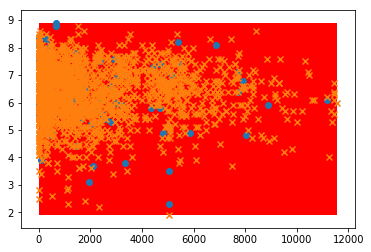

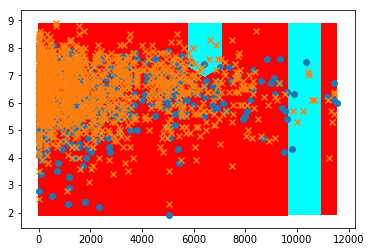

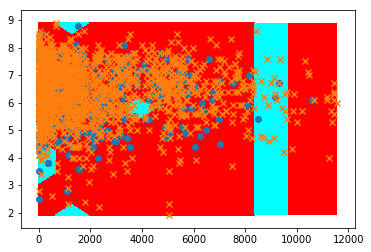

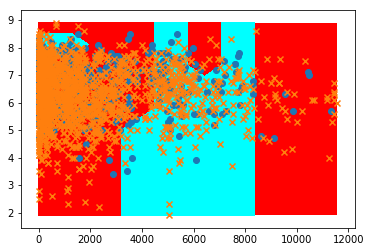

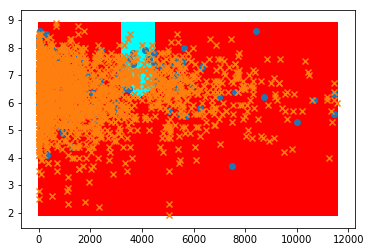

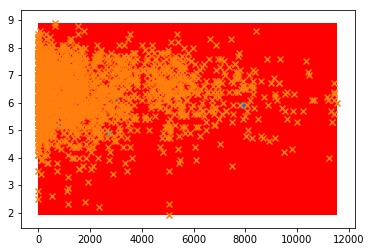

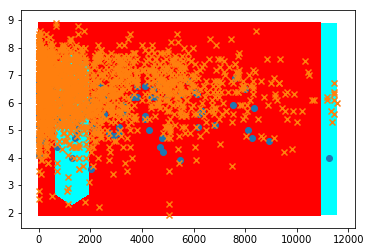

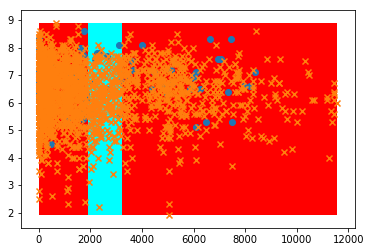

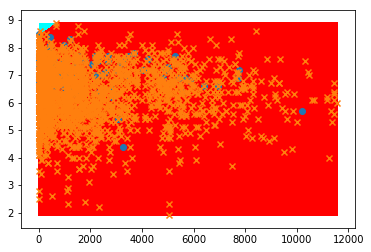

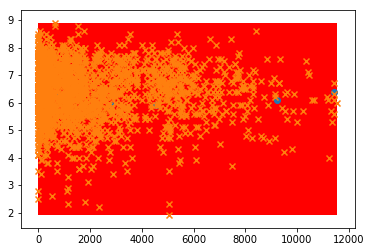

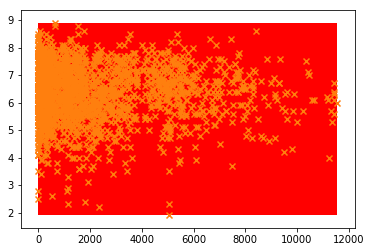

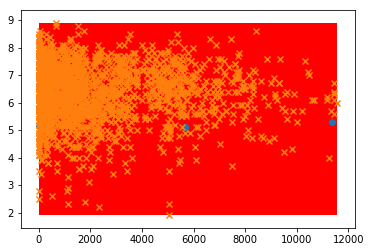

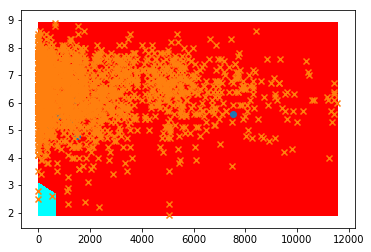

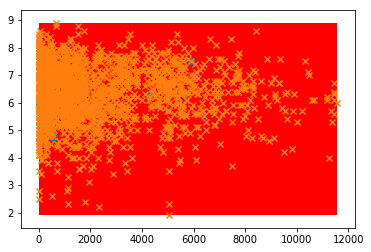

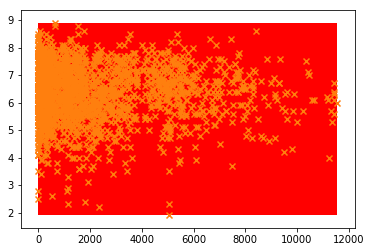

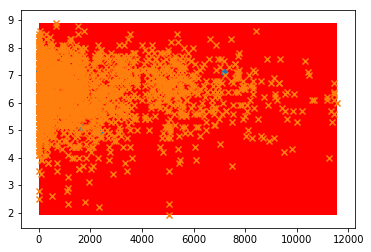

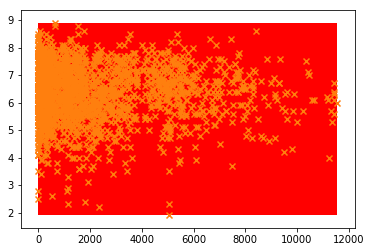

In [40]:
N=5
for cat in range(len(unique_categories)):
    tmp_train_set = ls.LabeledSet(train_set.x.shape[1])
    for vector, y in zip(train_set.x, train_set.y):
        if y[0] == cat:
            tmp_train_set.addExample(vector, 1)
        else:
            tmp_train_set.addExample(vector, -1)
            
    tmp_test_set = ls.LabeledSet(test_set.x.shape[1])
    for vector, y in zip(test_set.x, test_set.y):
        if y[0] == cat:
            tmp_test_set.addExample(vector, 1)
        else:
            tmp_test_set.addExample(vector, -1)
    
    # Perceptron
    # k = cl.KernelPoly()
    # perceptron_k = ClassifierPerceptronKernel(6,0.001,k)
    # perceptron_k = teste_perceptron(perceptron_k, tmp_train_set, N)
    
    # KNN
    knn = cl.ClassifierKNN(input_dimension=2, k=2)
    knn.train(tmp_train_set)
    print("Accuracy : {0}".format(knn.accuracy(tmp_test_set)))
    
    plt.figure()
    ut.plot_frontiere(tmp_test_set, knn)
    ut.plot2DSet(tmp_test_set)